In [9]:
'''
In this NoteBook, using dataset of movie recommendations provided by Carnigen Mellon University, I have completed the following: 


A/B) Implement both naive and warm-start soft-inpute algorithm against lambda_vals=logspace(0,3,30)
to impute the user's predictino of different movies. I picked stopping condition based on objective function, and pick the best lambda_val based on
i)num_iter until converg, ii)loss against train and test function, iii)rank of completed matrix


C) In addition, I derived the subgradient Methods for the same opitimization step, with step size n_k=1/k for the kth iteration
I compared the improvement behavior over 500 iterations against the softimpute methods and made the observations.

D) Then, I worked on implementing accelerated softimpute method by introduing momengtum, with
t_0=0,t_n=(1+sqrt(1+t_n-1**2))/2
delta_n=((t_n)-1)/(t_n+1), and let A_n+1=S_lambda(P_OMEGA(Y)+P_OMEGAT(B_n)),
B_n+1=A_n+1*(1-delta_n)+A_n*delta_n

E) Lastly, on the algorithmic side I also tested the alternating least square method, which is more general but whose main advantage is 
in its highly parallelizable nature, which can not be demonstrated here. In addition, it doesn't have the nice rank-auto-tuning 
properties enjoyed by softimpute, so this only provides a brief introduction

'''

#importing necessary packages 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from numpy.linalg import inv 
from numpy.linalg import norm

In [2]:
df_train=pd.read_csv("./data/train_copy.csv",header=None)
df_test=pd.read_csv("./data/test_copy.csv",header=None)
df_train.shape #(500, 500)
df_test.shape #(500, 500)
train_data=df_train.values
test_data=df_test.values

In [15]:
'''
A)
Input: Y=partially observed matrix, OMEGA=binary mask indicating none-zero values of Y
lambda_val=regularization parameter, B_init=initialization of B
max_iter=max number of iterations, tol=tolerance, stopping condition

Output: final completed matrix, B
'''

def soft_impute(Y,OMEGA,lambda_vals,max_iter=500,tol=10**(-4)):
    num_iters,Bs=[],[]
    #objective function: 0.5* Sq Frob Norm (P_OMEGA(Y-B)) + lambda*Nuclear Norm B
    for lambda_val in lambda_vals:
        B=np.zeros(Y.shape)
        prev_objective=np.inf
        num_iter=0
        while num_iter<=max_iter:
            #update B by the observed entries of Y
            B[OMEGA]=Y[OMEGA]
            #SVD of B
            U,S,VT=np.linalg.svd(B,full_matrices=False)
            #apply soft thresholding operator
            '''
            tried for-loop but this is highly inefficient b/c np.dot(m*1)*(1*n) is bad
            B+=(sing_val-lambda_val)*np.dot(U[:,index].reshape(-1,1),VT[index,:].reshape(1,-1))
            
            np.reshape(newrow,newcol),if lazy and don't want to calculation, put in -1 and 
            np will infer that number for you. 
            '''
            S_threshold=np.maximum(S-lambda_val,0)
            B=U@np.diag(S_threshold)@VT
            #calculate objective 
            cur_objective=0.5*np.linalg.norm(OMEGA*(Y-B))**2+lambda_val*np.sum(S_threshold)
            #decide continue or break 
            if abs(prev_objective-cur_objective)/prev_objective<tol:
                break 
            else:
                prev_objective=cur_objective
                num_iter+=1
        num_iters.append(num_iter)
        Bs.append(B)
    return Bs,num_iters
'''
Loss function, RootMeanSqaureLoss between Y and B on those observed entries 
'''
def loss(Y,OMEGA,B,nonzero_count):
    return np.linalg.norm(OMEGA*(Y-B))/np.sqrt(nonzero_count)

In [99]:
'''
selecting the best threshold value and for each threshold,
plotting i)# iter until converg ii)train/test root-mean-sq-loss iii)rank of solution
'''
train_nonzero_count=(train_data!=0).sum().sum()
train_mask=(train_data!=0)
test_nonzero_count=(test_data!=0).sum().sum()
test_mask=(test_data!=0)
lambda_vals=np.logspace(0,3,30)

soft_impute_naive=soft_impute(train_data,train_mask,lambda_vals)

/var/folders/_x/fh3t8wcj3_xbs4fddcxmbpc00000gn/T/ipykernel_92691/306500631.py:35: RuntimeWarning: invalid value encountered in double_scalars
  if abs(prev_objective-cur_objective)/prev_objective<tol:


KeyboardInterrupt: 

In [17]:
num_iterations=soft_impute_naive[1]
train_err,test_err,ranks=[],[],[]
for B in soft_impute_naive[0]:
    train_err.append(loss(train_data,train_mask,B,train_nonzero_count))
    test_err.append(loss(test_data,test_mask,B,test_nonzero_count))
    ranks.append(np.linalg.matrix_rank(B))

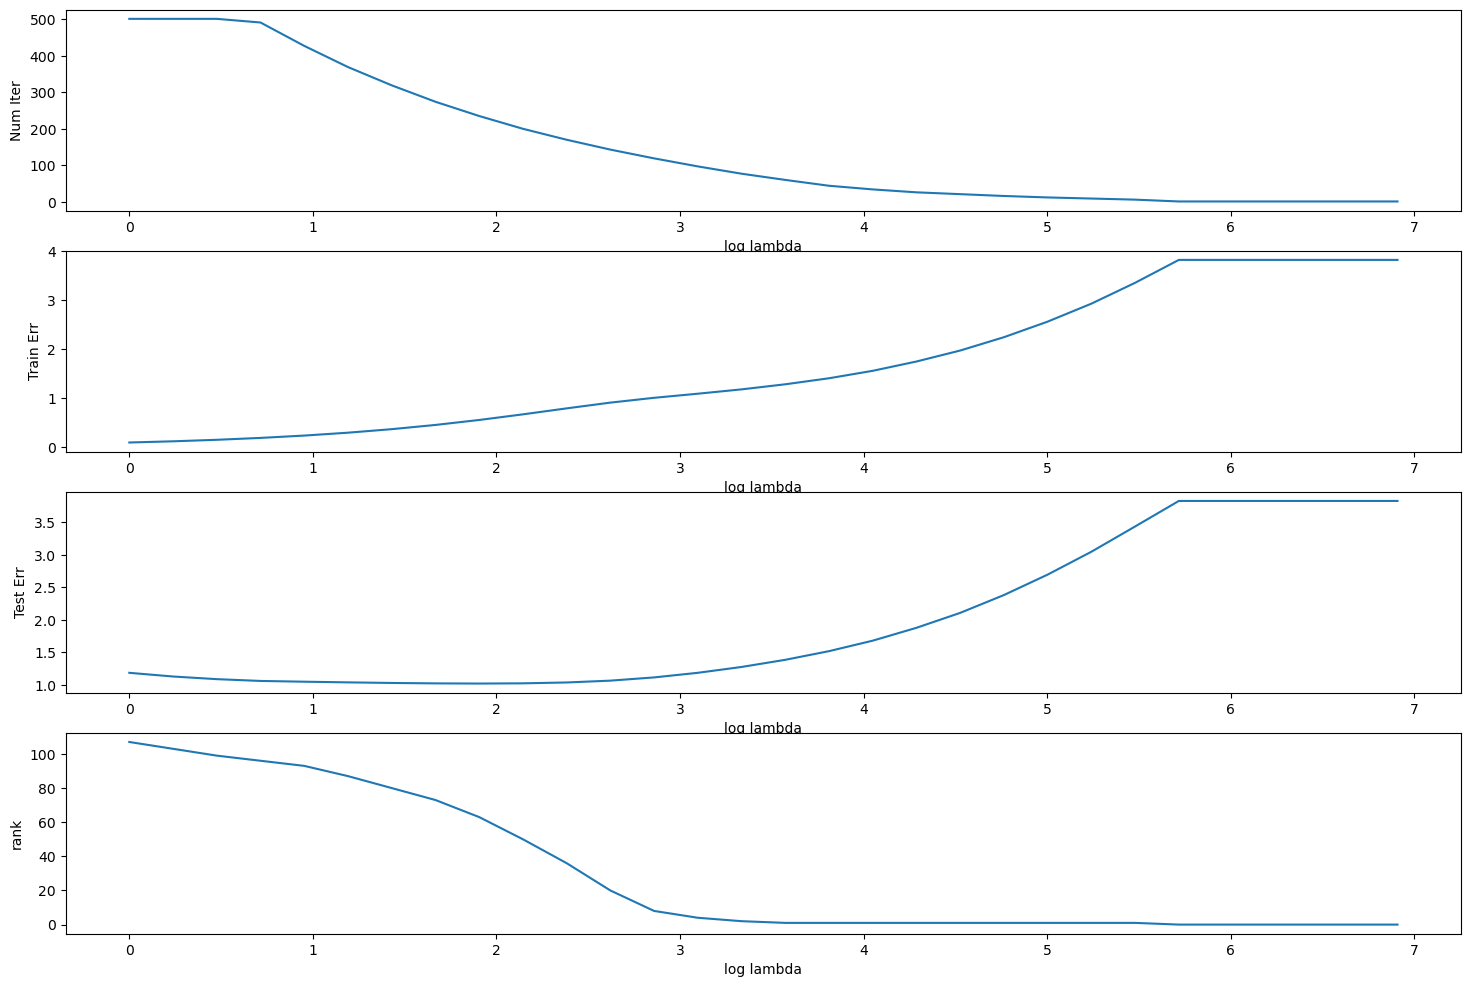

In [18]:
fig=plt.figure(figsize=(18,12))
log_lambdavals=[np.log(x) for x in lambda_vals]
data=[num_iterations,train_err,test_err,ranks]
names=["Num Iter","Train Err","Test Err","rank"]
for i in range(len(data)):
    ax=fig.add_subplot(len(data),1,i+1)
    ax.plot(log_lambdavals,data[i])
    ax.set(xlabel="log lambda",ylabel=names[i])
plt.show()

In [ ]:
'''
observations
1) num_iter until convergence: when lamba very small, essentially B becomes the exact 
copy of the training matrix, as there's no shrinkage. When lambda very big, convergence 
becomes faster as we are truncating a lot of values 
2) train_errr: always increasing as we are trying to generalize onto unknown entries 
while initially we are overfitting the training data 
2) test erorr: decreases then increases. in the beginning just copying the trianing set, so
doing a poor job, but regularization param being too large leads to underfitting
then increases; test_err starts off large, and the decreases, note that test_err reincreases
3) rank always decreases with stronger regularization  
'''

In [185]:
'''
B)
now implementing warm start: for each values of lambda, B gets initialized from the final 
version of the B from previous(LARGER!) lambda. Go from larger to smaller lambda values
because 
i)better to startoff underfitting than startoff overfitting, 
ii)more stable on initialization because we are gradually adding more info instead of removing them, 
iii)more efficient as we are not wasting any computation
ws=warm start
'''
def soft_impute_ws(Y,OMEGA,lambda_vals,max_iter=500,tol=10**(-4)):
    num_iters,Bs=[],[]
    B=np.zeros(Y.shape)
    for lambda_val in reversed(lambda_vals):
        prev_objective=np.inf
        num_iter=0
        while num_iter<=max_iter:
            #update B by the observed entries of Y
            B[OMEGA]=Y[OMEGA]
            #SVD of B
            U,S,VT=np.linalg.svd(B,full_matrices=False)
            #apply soft thresholding operator
            S_threshold=np.maximum(S-lambda_val,0)
            B=U@np.diag(S_threshold)@VT
            #calculate objective 
            cur_objective=0.5*np.linalg.norm(OMEGA*(Y-B))**2+lambda_val*np.sum(S_threshold)
            #decide continue or break 
            if abs(prev_objective-cur_objective)/prev_objective<tol:
                break 
            else:
                prev_objective=cur_objective
                num_iter+=1
        num_iters.append(num_iter)
        Bs.append(B.copy())
    num_iters.reverse()
    Bs.reverse()
    return Bs,num_iters


In [186]:
soft_impute_ws_data=soft_impute_ws(train_data,train_mask,lambda_vals)

/var/folders/_x/fh3t8wcj3_xbs4fddcxmbpc00000gn/T/ipykernel_22157/960258073.py:28: RuntimeWarning: invalid value encountered in double_scalars
  if abs(prev_objective-cur_objective)/prev_objective<tol:


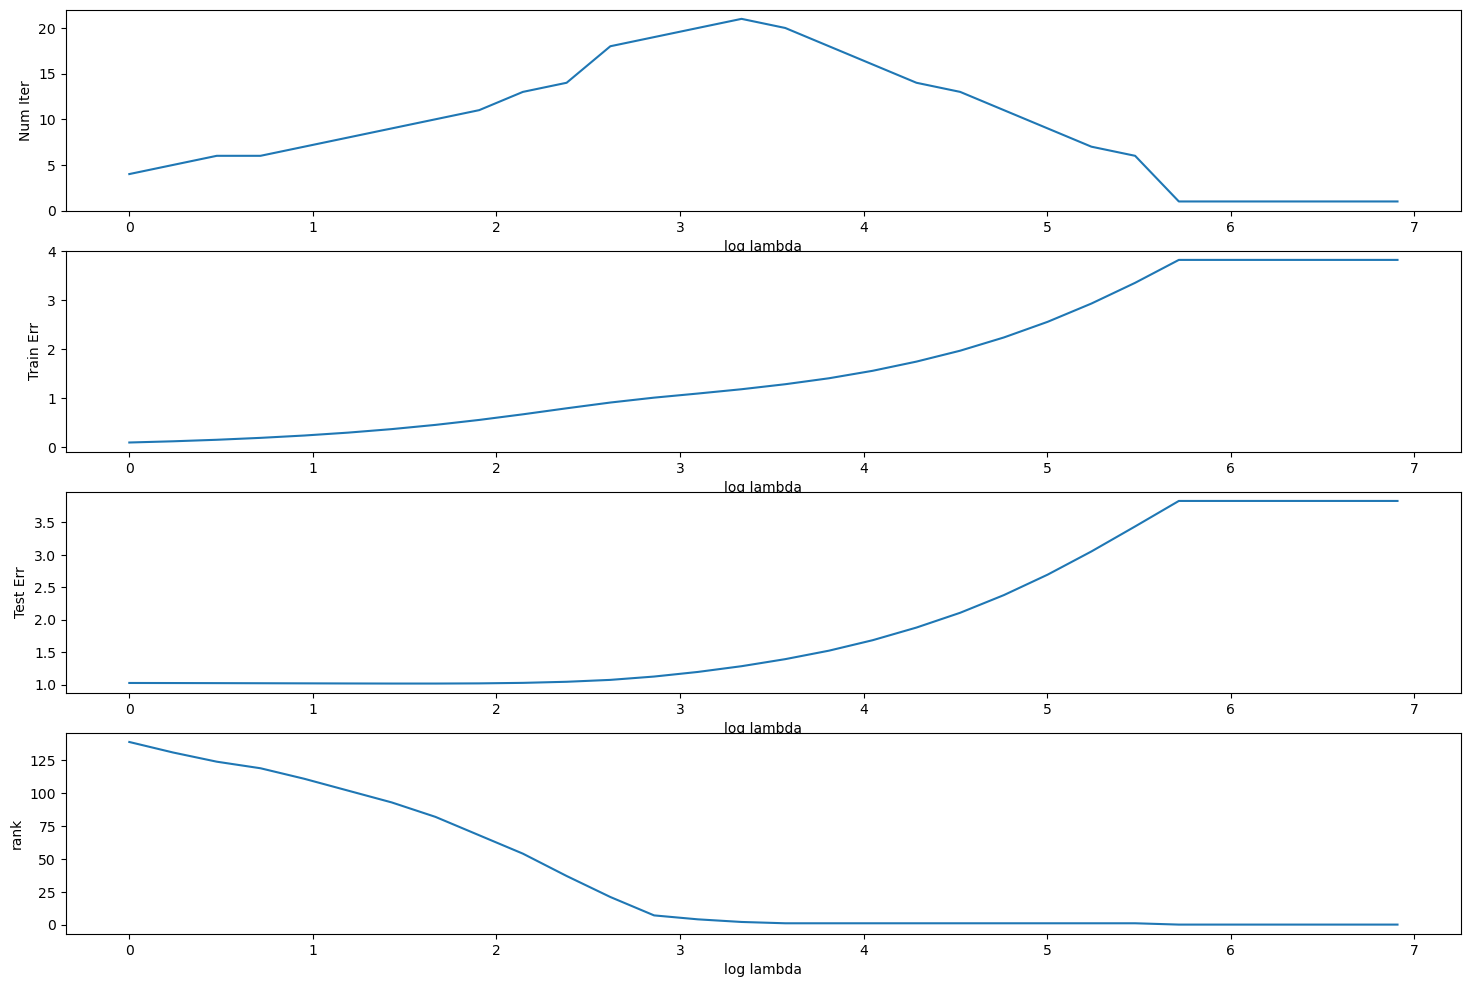

In [187]:
num_iterations_ws=soft_impute_ws_data[1]
train_err_ws,test_err_ws,ranks_ws=[],[],[]
for B in soft_impute_ws_data[0]:
    train_err_ws.append(loss(train_data,train_mask,B,train_nonzero_count))
    test_err_ws.append(loss(test_data,test_mask,B,test_nonzero_count))
    ranks_ws.append(np.linalg.matrix_rank(B))
fig=plt.figure(figsize=(18,12))
data_ws=[num_iterations_ws,train_err_ws,test_err_ws,ranks_ws]
for i in range(len(data_ws)):
    ax=fig.add_subplot(len(data_ws),1,i+1)
    ax.plot(log_lambdavals,data_ws[i])
    ax.set(xlabel="log lambda",ylabel=names[i])
plt.show() 

In [188]:
'''
observation: everything seems pretty good, observe that the warm start significantly 
decreases the time of computation 
'''

'\nobservation: everything seems pretty good, observe that the warm start significantly \ndecreases the time of computation \n'

In [200]:
'''
C) subgradient method and comparison with softimpute 
just update by P_OMEGA(B-Y)+lambda UVT, which is in the subdifferential  
'''

'''
both method_improve function returns sequence of objective function vals vs # iterations
'''
def subgradient_method_improve(Y,OMEGA,lambda_val,max_iter=500):
    B=np.zeros(Y.shape)
    objectives=[0.5*(np.linalg.norm(OMEGA*(Y-B)))**2]
    for i in range(max_iter):
        U,S,VT=np.linalg.svd(B,full_matrices=False)
        stepsize=1/(i+1)
        subgrad=OMEGA*(B-Y)+lambda_val*(U@VT)
        B-=stepsize*subgrad 
        nuclear_norm=np.sum(np.linalg.svd(B,full_matrices=False)[1])
        cur_objective=0.5*(np.linalg.norm(OMEGA*(Y-B)))**2+lambda_val*nuclear_norm
        objectives.append(min(objectives[-1],cur_objective))
    return objectives 

def softimpute_improve(Y,OMEGA,lambda_val,max_iter=500):
    B=np.zeros(Y.shape)
    objectives=[0.5*(np.linalg.norm(OMEGA*(Y-B)))**2+lambda_val*np.trace(B)]
    for i in range(max_iter):
        B[OMEGA]=Y[OMEGA]
        U,S,VT=np.linalg.svd(B,full_matrices=False)
        S_threshold=np.maximum(S-lambda_val,0)
        B=U@np.diag(S_threshold)@VT 
        objectives.append(0.5*(np.linalg.norm(OMEGA*(Y-B)))**2+lambda_val*np.sum(S_threshold))
    return objectives 


In [201]:
# lambda_vals_new=np.logspace(1,5,5)
# subgrad_history,softimpute_history=[],[]
# for lambda_val in lambda_vals_new:
#     subgrad_history.append(subgradient_method_improve(train_data,train_mask,lambda_val))
#     softimpute_history.append(softimpute_improve(train_data,train_mask,lambda_val))

lambda_vals_new=np.logspace(1,5,5)
subgrad_history=[]
for lambda_val in lambda_vals_new:
    subgrad_history.append(subgradient_method_improve(train_data,train_mask,lambda_val))

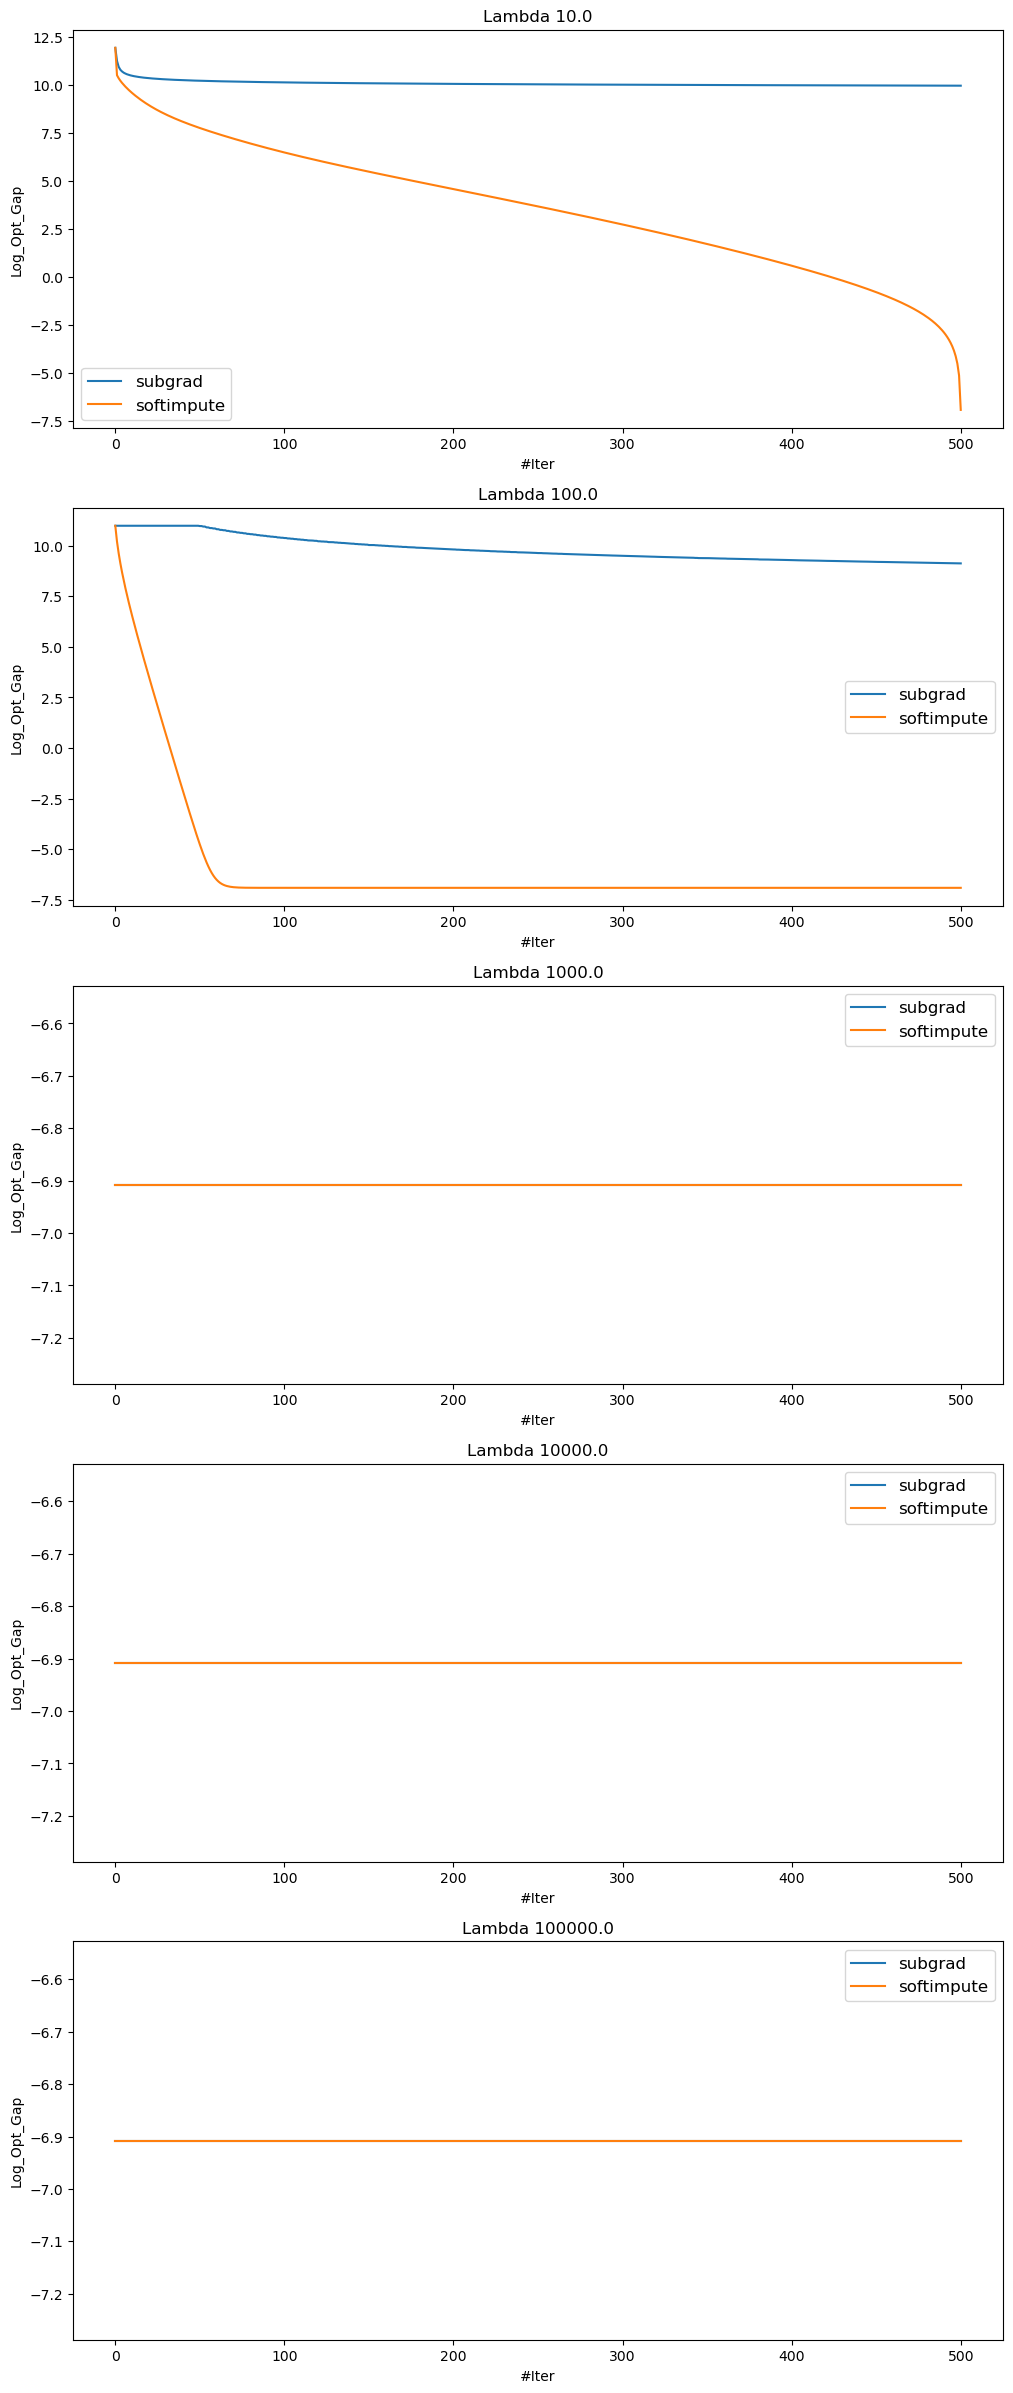

In [204]:
fig=plt.figure(figsize=(12,6*len(lambda_vals_new)))
xvals=list(range(501))
for index,lambda_val in enumerate(lambda_vals_new):
    ax=fig.add_subplot(len(lambda_vals_new),1,index+1)
    optval=min(subgrad_history[index][-1],softimpute_history[index][-1])
    subgrad_y=[np.log(val-optval+10**(-3)) for val in subgrad_history[index]]
    softimpute_y=[np.log(val-optval+10**(-3)) for val in softimpute_history[index]]
    ax.plot(xvals,subgrad_y,label="subgrad")
    ax.plot(xvals,softimpute_y,label="softimpute")
    ax.set(xlabel="#Iter",ylabel="Log_Opt_Gap",title="Lambda {}".format(lambda_val))
    ax.legend(fontsize=12)
plt.show()


In [207]:
'''
d) accelerated matrix completion
'''

def soft_impute_accelerated(Y,OMEGA,lambda_vals,max_iter=500,tol=10**(-4)):
    num_iters,Bs=[],[]
    for lambda_val in lambda_vals:
        B=np.zeros(Y.shape)
        A=np.copy(B)
        t=1
        prev_objective=np.inf
        num_iter=0
        while num_iter<=max_iter:
            #softimpute
            B[OMEGA]=Y[OMEGA]
            U,S,VT=np.linalg.svd(B,full_matrices=False)
            S_threshold=np.maximum(S-lambda_val,0)
            A_new=U@np.diag(S_threshold)@VT
            #calculate t_n and delta_n 
            t_new=(1+np.sqrt(4*t**2+1))/2
            delta=(t_new-1)/t 
            t=t_new
            #update B and A
            B=(1-delta)*A_new+delta*A
            A=A_new
            #calculate objective 
            cur_objective=0.5*np.linalg.norm(OMEGA*(Y-B))**2+lambda_val*np.sum(S_threshold)
            #decide continue or break 
            if abs(prev_objective-cur_objective)/prev_objective<tol:
                break 
            else:
                prev_objective=cur_objective
                num_iter+=1
        num_iters.append(num_iter)
        Bs.append(B)
    return Bs,num_iters

In [208]:
soft_impute_accelerated_data=soft_impute_accelerated(train_data,train_mask,lambda_vals)

/var/folders/_x/fh3t8wcj3_xbs4fddcxmbpc00000gn/T/ipykernel_22157/516363299.py:29: RuntimeWarning: invalid value encountered in double_scalars
  if abs(prev_objective-cur_objective)/prev_objective<tol:


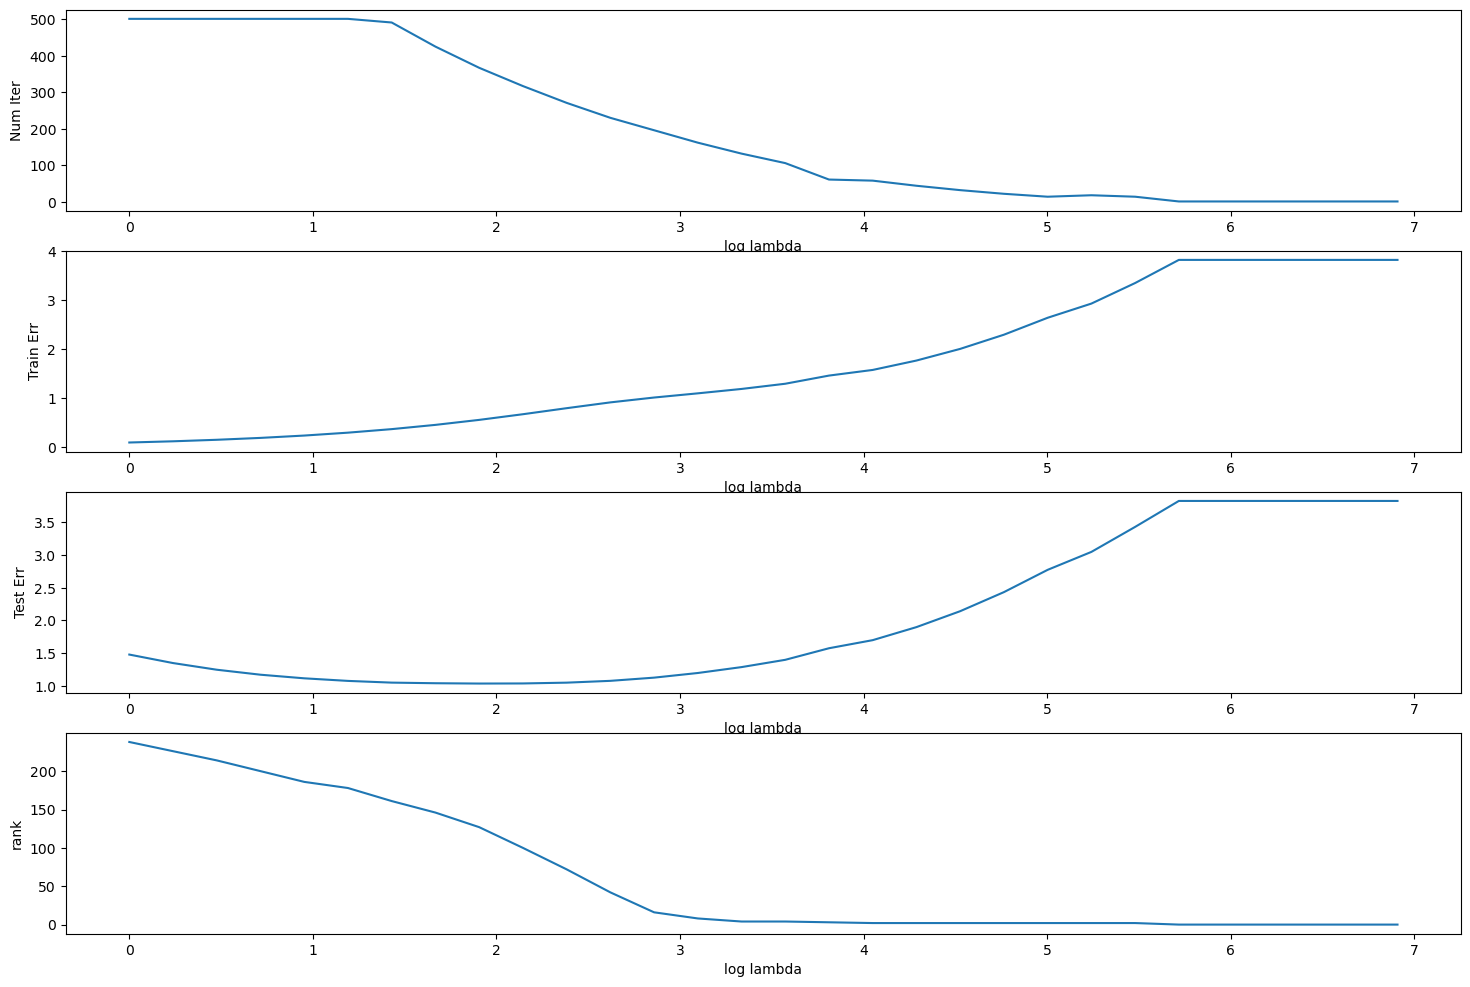

In [209]:
num_iterations_accelerated=soft_impute_accelerated_data[1]
train_err_accelerated,test_err_accelerated,ranks_accelerated=[],[],[]
for B in soft_impute_accelerated_data[0]:
    train_err_accelerated.append(loss(train_data,train_mask,B,train_nonzero_count))
    test_err_accelerated.append(loss(test_data,test_mask,B,test_nonzero_count))
    ranks_accelerated.append(np.linalg.matrix_rank(B))

fig=plt.figure(figsize=(18,12))
data_accelerated=[num_iterations_accelerated,train_err_accelerated,test_err_accelerated,ranks_accelerated]
names=["Num Iter","Train Err","Test Err","rank"]
for i in range(len(data_accelerated)):
    ax=fig.add_subplot(len(data_accelerated),1,i+1)
    ax.plot(log_lambdavals,data_accelerated[i])
    ax.set(xlabel="log lambda",ylabel=names[i])
plt.show()

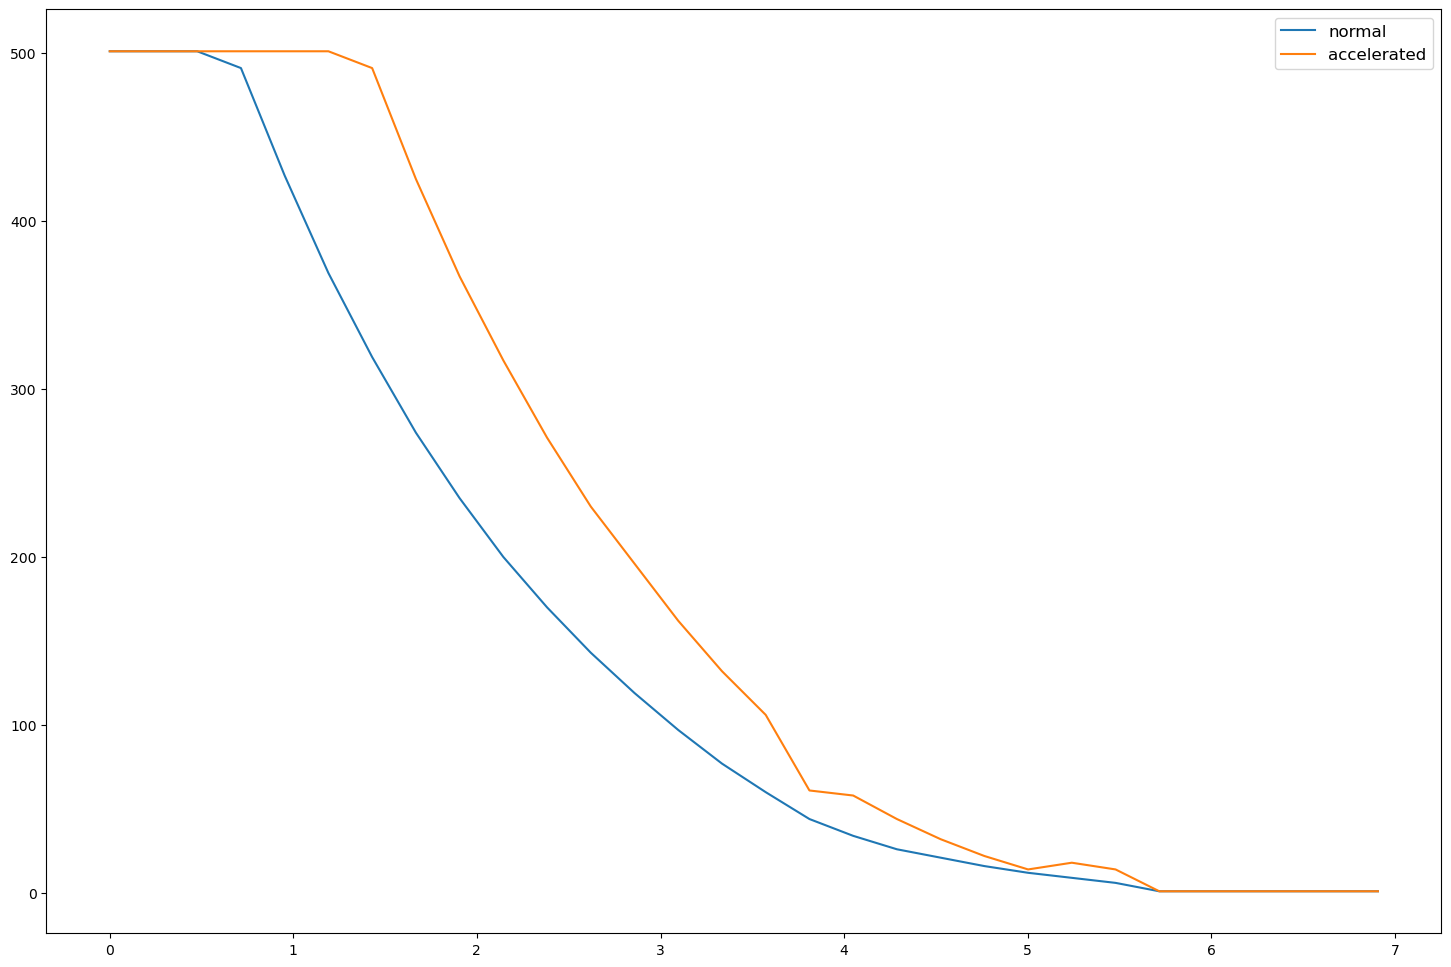

In [211]:
fig=plt.figure(figsize=(18,12))
ax=fig.add_subplot()
ax.plot(log_lambdavals,num_iterations,label="normal")
ax.plot(log_lambdavals,num_iterations_accelerated,label="accelerated")
ax.legend(fontsize=12)
plt.show()

In [194]:
'''
e)Alternating Least Square for Matrix Completion,
input: Y:the partially observed matrix, rank:desired rank of the matrix factors, lambda=regularization param
         max_iter:max number of iterations, tol:tolerance for stopping condition

Observed that random initialization for A and B gives a final loss of about 51000, so did SDV initialization
'''
def als(Y,OMEGA,rank,lambda_val,max_iter=500,tol=10**(-4)):
    m,n=Y.shape
    #initialization very important, as final result is sensitive to it
    U,S,VT=np.linalg.svd(Y,full_matrices=False)
    A,B=U[:,:rank].T,VT[:rank,:]
    lambda_I=np.eye(rank)*lambda_val
    loss=norm(OMEGA*(Y-A.T@B))**2+lambda_val*(norm(A)**2+norm(B)**2)
    loss_history=[]
    num_iter=0 
    while (num_iter<max_iter):
        #Alternating between fixing A/B and minimizing loss with respect to B/A
        for u in range(m):
            A[:,u]=np.linalg.solve(lambda_I+(OMEGA[u,:]*B)@B.T,B@(Y[u,:].T))
        for i in range(n):
            B[:,i]=np.linalg.solve(lambda_I+A@(OMEGA[:,i].reshape(-1,1)*A.T),A@Y[:,i])
        newloss=norm(OMEGA*(Y-A.T@B))**2+lambda_val*(norm(A)**2+norm(B)**2)
        loss_history.append(newloss)
        if abs(loss-newloss)<tol:
            break 
        loss=newloss
        num_iter+=1
    return A,B,loss_history


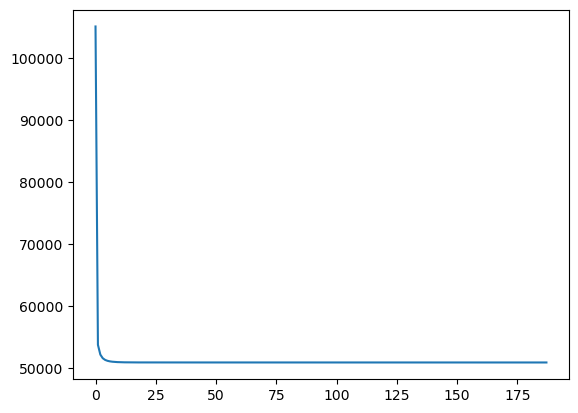

In [195]:
lambda_vals=np.logspace(0,3,10)
lambda_val=10
rank=5 
A,B,loss_history=als(train_data,train_mask,rank,lambda_val)
fig,ax=plt.subplots()
ax.plot(list(range(len(loss_history))),loss_history)
plt.show()

In [166]:
opt_model=als_ws(train_data,list(range(2,15)),lambda_vals=np.logspace(0,3,30))
opt_model["loss"]
'''
TO THINK:
since choosing the best lambda value is pretty difficult, as here the loss function itself is defined with lambda,
we will do an automatic k-fold cross validation. 
'''


199838.38807764178